## Game_Name_Here balacing tool 

this tool is written by Adelina Jasko and inteded to ouput continous values for the game_name_here ran with random user inputer over a given amount of time. 

In [11]:
# imports 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

In [22]:
# sim config
# config
gametime_in_minutes = 0.4   
tickrate = 0.1    # 1 tick per second, implying a simulation timescale of 1 to 1 for real time, increase to speed up simulation
                # setting this to .1 will simulate 6 minutes of gameplaying in 1 minute, setting to high can break the simulation
simulation_time = 60 * gametime_in_minutes  # 5 minutes, simulation time in seconds
interaction_freq = 1/4                    # 1/15 implies roughly 4 % chance player uses a card called once per second
results_as_xlsx = False                     # if True, results are saved as xlsx in the same folder as the script
logging = True                              # if True, logs are printed to console

In [23]:
# config and function setup
# Start stats
gold = 10
gps = 0
population = 0
happiness = 25
p_hf = 1
pollution = 0
pol_fact = 1
pol_to_hap_ratio = 1000 # rate by which pollution affects happiness, calculed as happines factor - 1/pol_to_hap_ratio * pollution
# for random simulation gold per second / population relation is currently hardcoded into cards
# rather than being included in game update
cards = [
    {
        "name" : "residential",
        "cost" : 10,
        "population" : 5,
        "gold_gain" : 0,
        "gold_per_second" : 0.5,
        "init_pollution" : 0.1,
        "pollution" : 0.01,
        "init_happiness" : 0,
        "happiness" : 0
    },
    {
        "name" : "eco",
        "cost" : 15,
        "population" : 5,
        "gold_gain" : 0,
        "gold_per_second" : 0.25,
        "init_pollution" : 0,
        "pollution" : 0,
        "init_happiness" : 0,
        "happiness" : 0
    },
    {
        "name" : "industry",
        "cost" : 0,
        "population" : 0,
        "gold_gain" : 30,
        "gold_per_second" : 0.25,
        "pollution" : 0.025,
        "init_pollution" : 2,
        "init_happiness" : 0,
        "happiness" : 0
    },
    {
        "name" : "Deco",
        "cost" : 30,
        "population" : 0,
        "gold_gain" : 30,
        "gold_per_second" : 0.02,
        "pollution" : 0.0,
        "init_pollution" : 0.005,
        "init_happiness" : 1,
        "happiness" : 0.025

    },
    {
        "name" : "skip",
        "cost" : 0,
        "population" : 0,
        "gold_gain" : 0,
        "gold_per_second" : 0,
        "pollution" : 0,
        "init_pollution" : 0.0,
        "init_happiness" : 0,
        "happiness" : 0
    }
]

# utility functions
def get_time_delta(start_time):
    return time.time() - start_time

# called every second
def update(p_gold, p_gps, p_population, p_pollution, p_pf, p_happiness, p_hf) :
    gold = p_gold + p_gps
    pollution = p_pollution * p_pf
    if pollution != 0:
        # current facor relation is 1 to 1 pollution to happiness
        happiness_factor = p_hf - pollution / pol_to_hap_ratio 
    else:
        happiness_factor = p_hf
        
    happiness = p_happiness * happiness_factor
    card_played = False
    if (random.random() > 1- interaction_freq):
        card_chosen = cards[random.randint(0, len(cards)-1)]
        if gold >= card_chosen["cost"]:   
            card_played = True 
            card_name = card_chosen["name"]
            gold = gold - card_chosen["cost"] + card_chosen["gold_gain"]
            population = p_population + card_chosen["population"]
            happiness = p_happiness + card_chosen["init_happiness"] 
            pollution = pollution + card_chosen["init_pollution"]
            happiness_factor = p_hf + card_chosen["happiness"]
            gold_per_second = p_gps + card_chosen["gold_per_second"]
            pollution_factor = p_pf + card_chosen["pollution"]

    if (card_played == False):
        card_name = "no_action"
        gold = gold
        gold_per_second = p_gps
        happiness = happiness
        happiness_factor = p_hf 
        pollution = pollution
        pollution_factor = p_pf
        population = p_population 
        
        
    return {
            "card_played" : card_played,
            "card_name" : card_name,
            "gold" : gold,
            "gold_per_second" : gold_per_second,
            "population" : population,
            "happiness" : happiness,
            "happiness_factor" : happiness_factor,
            "pollution" : pollution,
            "pollution_factor" : pollution_factor
        } 
   


In [24]:
# logging setup
headers = ["time_delta","card_name","gold","population","happiness","pollution"]
log_dict = {
    "time_delta" : [0],
    "card_name" : ["start"],
    "gold" : [gold],
    "population" : [population],
    "happiness" : [happiness],
    "pollution" : [pollution]
}

# simulation varibales setting
start_time = time.time()
time_delta = 0
card_name = "start"

while get_time_delta(start_time) < simulation_time:
    
    if pollution > 100:
        print("pollution too high, game over")
        break
    
    if happiness < 1:
        print("happiness too low, game over")
        break
    
    action_check = update(gold, gps, population, pollution, pol_fact, happiness, p_hf)

    card_name = action_check["card_name"]
    gold = action_check["gold"]
    gps = action_check["gold_per_second"]
    population = action_check["population"]
    happiness = action_check["happiness"]
    p_hf = action_check["happiness_factor"]
    pollution = action_check["pollution"]
    pol_fact = action_check["pollution_factor"]

    
    time_delta = round(get_time_delta(start_time),2)
    log_dict["time_delta"].append(time_delta)
    log_dict["card_name"].append(card_name)
    log_dict["gold"].append(gold)
    log_dict["population"].append(population)
    log_dict["happiness"].append(happiness)
    log_dict["pollution"].append(pollution)

    if logging:
        print(f"used card {card_name} at {time_delta} seconds ingame\n -- Population: {population}\n -- Cash: {gold}\n -- Pollution: {pollution}\n -- Happiness: {happiness}")
    
    time.sleep(tickrate)

    # end of loop

print(f"game ended after {time.time() - start_time}\nLog is:\n{log_dict}")

sim_df = pd.DataFrame(log_dict)

# make time_delta the index
sim_df.set_index("time_delta", inplace=True)

# add card name as second index
sim_df.set_index("card_name", append=True, inplace=True)

print(sim_df.head())

# store sim_df with the current date attached to the filename as xlsx
if results_as_xlsx:
    sim_df.to_excel(f"sim_log_{time.strftime('%Y-%m-%d-%H-%M-%S')}.xlsx")

used card no_action at 0.0 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.11 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.21 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.31 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.41 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.51 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.61 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.71 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action at 0.81 seconds ingame
 -- Population: 0
 -- Cash: 10
 -- Pollution: 0
 -- Happiness: 25
used card no_action 

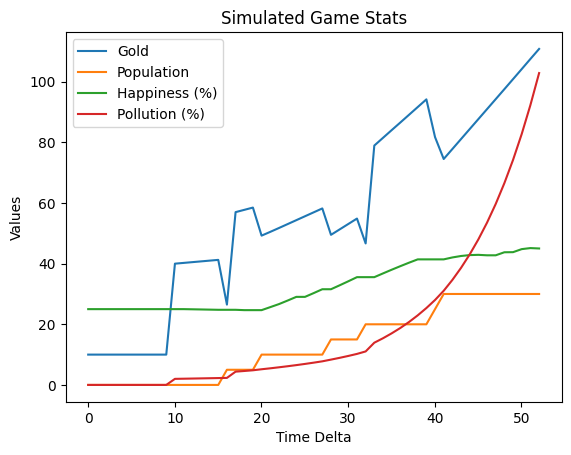

In [18]:
# plot the simulation using plotly and time_delta, card_name as x-axis
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(sim_df.index.get_level_values('time_delta'), sim_df['gold'], label='Gold')
ax.plot(sim_df.index.get_level_values('time_delta'), sim_df['population'], label='Population')
ax.plot(sim_df.index.get_level_values('time_delta'), sim_df['happiness'], label='Happiness (%)')
ax.plot(sim_df.index.get_level_values('time_delta'), sim_df['pollution'], label='Pollution (%)')

# Set the title and labels
ax.set_title("Simulated Game Stats")
ax.set_xlabel("Time Delta")
ax.set_ylabel("Values")

# Add a legend
ax.legend()

# Show the plot
plt.show()


